

### Cel projektu: Implementacja przekształceń:
    1.Przekształcenie afiniczne zdefiniowane przez 4 wartości (TA-TD). Dla RGB każda warstwa osobno
    2.Filtracja entropii -funkcja przyjmuje jako argumenty obraz i szerokość okna. Program konwolucyjnie wylicza wartość   entropii a następnie powstały obraz normalizuje do przedziału <0;255> 
    3.Zamknięcie elementem linijnym o zadanej długości i nachyleniu
    4.Mapa odległości geodezyjnej od zadanego punktu wewnątrz obiektu. Wynik znormalizować
    
### Użyte technologie: 
projekt został napisany w języku Python

In [3]:
from matplotlib import image
from matplotlib import pyplot as plt
from matplotlib import pyplot
import numpy as np
import math

In [4]:
from PIL import Image

### Wczytanie obrazów do testowania algorytmów

In [129]:
mono = image.imread('cameraman.bmp')
color = image.imread('peppers.jpg')
logical = image.imread('dziury.bmp')
logical=logical[:,:,0]

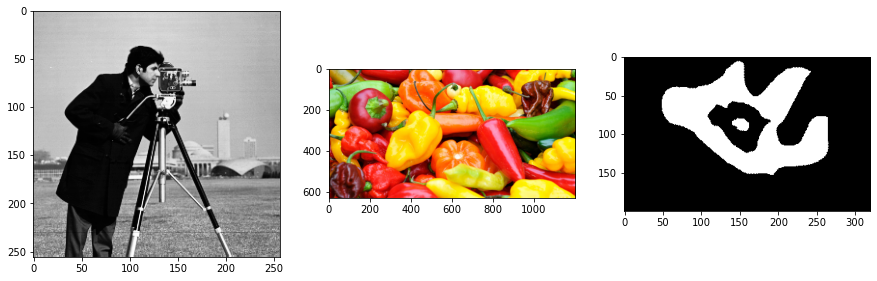

In [4]:
plt.figure(figsize=(15, 10))
plt.subplot(131).imshow(mono, cmap="Greys_r")
plt.subplot(132).imshow(color, cmap="Greys_r")
plt.subplot(133).imshow(logical, cmap="Greys_r")

##### funkcja pomocnicza do sprawdzania rodzaju obrazu:

In [6]:
def image_type(src_image):
    try:
        height, width, channels = src_image.shape
    except ValueError:
        height, width = src_image.shape
        channels = None
    if channels:
        return 'RGB'

    for x in range(height):
        for y in range(width):
            if src_image[x, y] != 0 and src_image[x, y] != 255:
                return 'mono'

    return 'logical'

## 1.Przekształcenie afiniczne zdefiniowane przez 4 wartości (TA-TD). Dla RGB każda warstwa osobno [mono+logiczne]

Wykonuję przekształcenie o macierz 2x2 [a b, c d].

Do wyliczenia x' i y' korzystam ze wzorów:

x'=ax+by

y'cx+dy


In [6]:
def affineTransformation(img):
    if image_type(img) == 'RGB':
        height,width,chanel = img.shape[:3]
            
    else:
        height,width = img.shape[:2]
    
    
    print('Podaj macierz [ a b; c d]')
    m = [[0,0], [0,0]]
    for i in range(2):
        for j in range(2):
            m[i][j] = float(input())
 
    
    h_out = int(height * m[1][1] + abs(m[1][0]) * width)
    w_out = int(width * m[0][0] + abs(m[0][1]) * height)
   
    if image_type(img) == 'RGB':
        image_out = np.zeros((h_out + 1, w_out + 1,chanel), np.uint8) 
    else:
        image_out = np.zeros((h_out + 1, w_out + 1), np.uint8)
    

    for y0 in range(height):
        for x0 in range(width):
            y = int(x0 * m[1][0] + y0 * m[1][1])
            x = int(x0 * m[0][0] + y0 * m[0][1])

            if 0 < y < h_out and 0 < x < w_out:
                image_out[y,x] = img[y0,x0]
                image_out[y + 1,x] = img[y0,x0]
                image_out[y,x + 1] = img[y0,x0]
                image_out[y + 1,x + 1] = img[y0,x0]
                
    plt.figure(figsize=(15, 10))
    plt.subplot(121).imshow(img, cmap="Greys_r")
    plt.subplot(122).imshow(image_out, cmap="Greys_r")  
    
    tmp=Image.fromarray(image_out)
    tmp.save(fp="AffineTransformation-{}.jpeg".format(image_type(img)),format="JPEG")
            
    return 0

##### Wyniki dzialania programu dla macierzy [0.5 1; 1 0.5]:

Podaj macierz [ a b; c d]
0.5
1
1
0.5


0

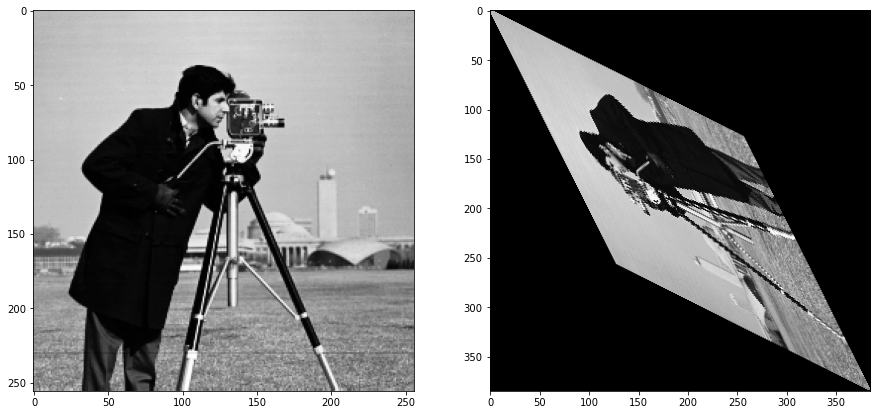

In [7]:
affineTransformation(mono)

Podaj macierz [ a b; c d]
0.5
1
1
0.5


0

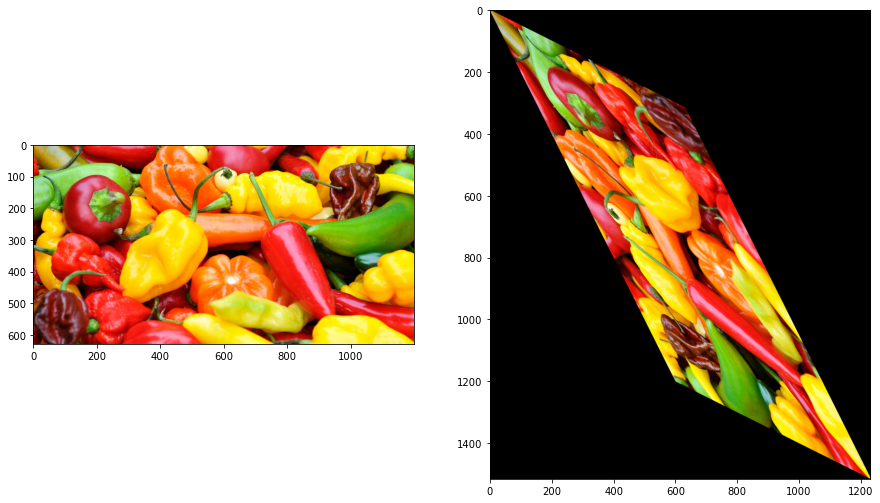

In [8]:
affineTransformation(color)

## 2.Filtracja entropii -funkcja przyjmuje jako argumenty obraz i szerokość okna. Program konwolucyjnie wylicza wartość entropii a następnie powstały obraz normalizuje do przedziału <0;255> [RGB+mono]

Funkcja jako parametry wejściowe przyjmuje obraz i podaną w czasie trwania programu szerokość okna. Program 
konwolucyjnie wylicza wartość entropii.Następnie powstały obraz zostaje znormalizowany do przedziału <0;255>

In [9]:
def calculate_histogram(src_channel):
    hist = np.zeros(256)
    for i in src_channel:
        hist[i] += 1
    return hist

In [10]:
def entropy(region):
    if image_type(region) == 'RGB':
        histR=calculate_histogram(region[:, :, 0].flatten())/ (region.shape[0] * region.shape[1])
        histG=calculate_histogram(region[:, :, 1].flatten())/ (region.shape[0] * region.shape[1])
        histB=calculate_histogram(region[:, :, 2].flatten())/ (region.shape[0] * region.shape[1])
        hR = list(filter(lambda p: p > 0, histR))
        hG = list(filter(lambda p: p > 0, histG))
        hB = list(filter(lambda p: p > 0, histB))
        histogram=hR+hG+hB
    else:
        histogram = calculate_histogram(region.flatten()) / (region.shape[0] * region.shape[1])
        histogram = list(filter(lambda p: p > 0, histogram))
    
    #calculate entropy
    entropy_val = -np.sum(np.multiply(np.log(histogram), histogram))

    return entropy_val

In [11]:
def entropy_filter(image):
    mask_size=int(input("Podaj szerokosc okna: "))
    mask_half = math.floor(mask_size/2)
    img_height, img_width = image.shape[:2]
    result_image = np.zeros((img_height, img_width))

    for i in range(img_height):
        for j in range(img_width):

            lx = np.max([0, j - mask_half])
            ux = np.min([img_width, j + mask_half])
            ly = np.max([0, i - mask_half])
            uy = np.min([img_height, i + mask_half])
            region = image[ly:uy, lx:ux]

            res = entropy(region)
            result_image[i, j] = res

    
    min_entropy = min(result_image.flatten())
    max_entropy = max(result_image.flatten())
    result_image = (result_image - min_entropy) / (max_entropy - min_entropy) * 255
    result_image = result_image.astype(np.uint8)
    
    tmp=Image.fromarray(result_image)
    tmp.save(fp="EntropyFilter-{}.jpeg".format(image_type(image)),format="JPEG")
    
    plt.figure(figsize=(15, 10))
    plt.subplot(121).imshow(image, cmap="Greys_r")
    plt.subplot(122).imshow(result_image, cmap="Greys_r")
    return 0

##### Wyniki dzialania programu dla okna o szerokosci 5:

Podaj szerokosc okna: 5


0

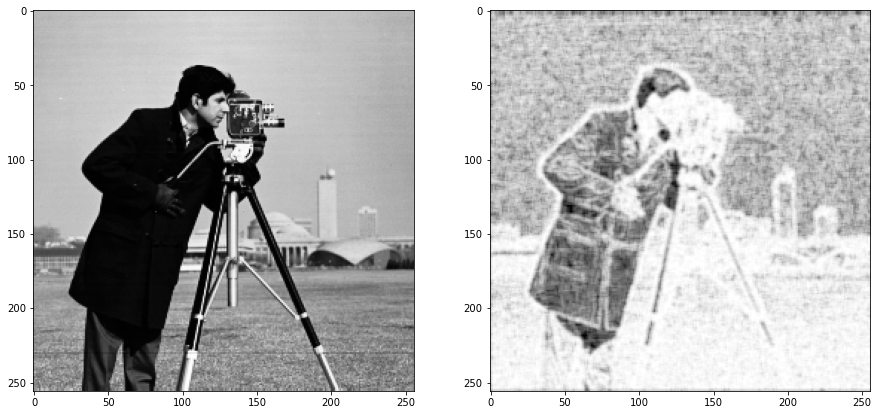

In [12]:
entropy_filter(mono)

Podaj szerokosc okna: 5


0

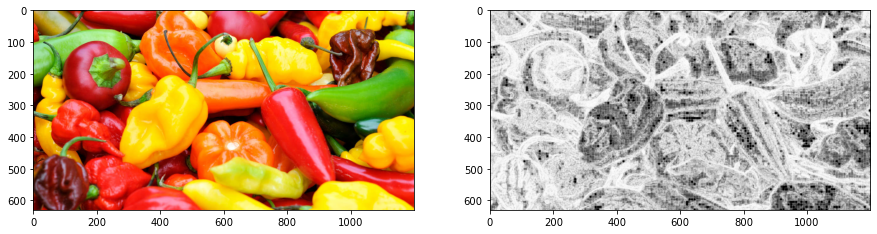

In [13]:
np.seterr(divide='ignore', invalid='ignore')
entropy_filter(color)

## 3.Zamknięcie elementem linijnym o zadanej długości i nachyleniu[mono+logiczne]

Funkcja jako parametr wejściowy przyjmuje obraz i podaną w czasie trwania programu długość elementu oraz kąt nachylenia.
Korzystając z algorytmu Bresenhama zostaje stworzony liniowy element strukturalny, za pomocą którego wykonywana jest na obrazie dylatacja i erozja


In [14]:
def erode(image, se):
    res = np.zeros_like(image)
    
    width,height = image.shape[:2]
    mask_x, mask_y = se.shape[:2]
    
    half_mask_x = mask_x // 2
    half_mask_y = mask_y // 2
    for x in range(math.ceil(mask_x / 2), width - mask_x // 2):
        for y in range(math.ceil(mask_y / 2), height - half_mask_y):
            on = image[x - half_mask_x:x + half_mask_x + 1, y - half_mask_y: y + half_mask_y + 1]
            res[x, y] = min(on[(se == 1)])
            
    return res

In [15]:
def dilate(image, se):
    res = np.zeros_like(image)
    width,height = image.shape[:2]
    mask_x, mask_y = se.shape[:2]
    half_mask_x = mask_x // 2
    half_mask_y = mask_y // 2
    
    for x in range(math.ceil(mask_x / 2), width - mask_x // 2):
        for y in range(math.ceil(mask_y / 2), height - half_mask_y):
            on = image[x - half_mask_x:x + half_mask_x + 1, y - half_mask_y: y + half_mask_y + 1]
            res[x, y] = max(on[(se == 1)])
            
    return res

In [16]:
def line(x1, y1, x2, y2):
    
    #implementation Bresenham's Line Generation Algorithm  
    dx = x2 - x1
    dy = y2 - y1
    is_steep = abs(dy) > abs(dx)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    dx = x2 - x1
    dy = y2 - y1
    error = int(dx / 2.0)
    y_step = 1 if y1 < y2 else -1
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += y_step
            error += dx
    if swapped:
        points.reverse()
    return points

In [17]:
def linear_se(length, angle):
    
    #create linear structuring element with length and angle:
    theta = math.radians(angle)
    dx = abs(math.cos(theta))
    dy = abs(math.sin(theta))
    
    lgx = length * dx
    n2x = round((lgx - 1) / 2)
    nx = 2 * n2x + 1
    
    lgy = length * dy
    n2y = round((lgy - 1) / 2)
    ny = 2 * n2y + 1
    
    res = np.zeros([ny, nx])
    if math.cos(theta) >= 0:
        points = line(0, ny - 1, nx - 1, 0)
    else:
        points = line(nx - 1, ny - 1, 0, 0)
        
    #structuring element:    
    for x in points:
        res[x[1], x[0]] = 1
        
    return res

In [18]:
def close(img):
    length=int(input("Podaj dlugosc: "))
    angle=int(input("Podaj kat nachylenie: "))
    lse = linear_se(length, angle)

    step1 = dilate(img, lse);
    result = erode(step1, lse);
    
    
    tmp=Image.fromarray(result)
    tmp.save(fp="CloseLine-{}.jpeg".format(image_type(img)),format="JPEG")
    
    plt.figure(figsize=(15, 10))
    plt.subplot(121).imshow(img, cmap="Greys_r")
    plt.subplot(122).imshow(result, cmap="Greys_r")
    return 0;

##### Wyniki dzialania programu dla elementu linijnego o dlugosci 20 i kacie nacylenia 40:

Podaj dlugosc: 20
Podaj kat nachylenie: 40


0

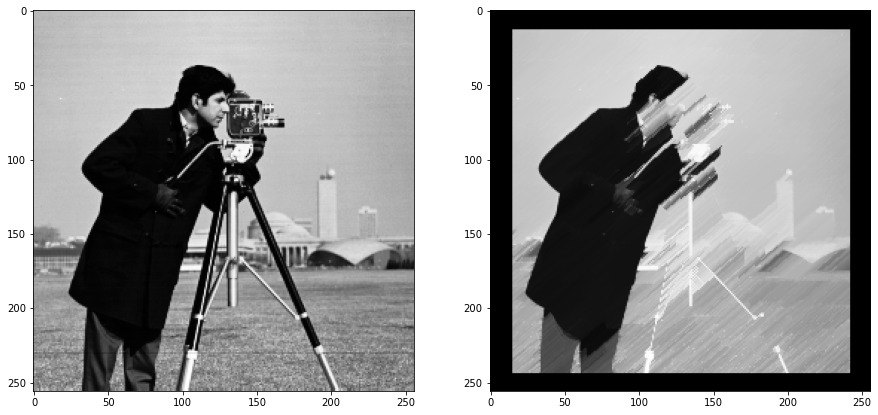

In [19]:
close(mono)

Podaj dlugosc: 20
Podaj kat nachylenie: 40


0

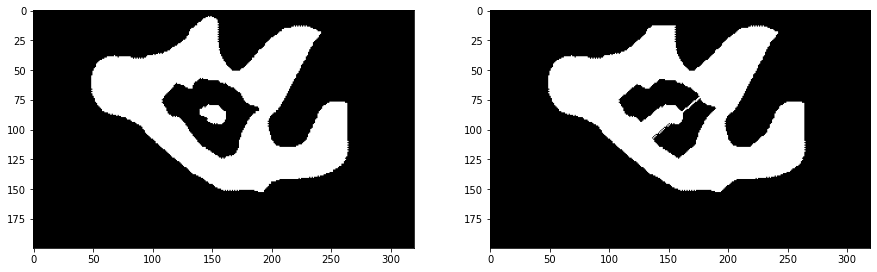

In [20]:
close(logical)

## 4.Mapa odległości geodezyjnej od zadanego punktu wewnątrz obiektu. Wynik znormalizować[logiczne] 

Funkcja na wejściu przyjmuje obraz, w trakcie trwania programu pobiera współrzędne pktA. Najpierw zostaje stworzona tablica wypełniona zerami(marker) ,następnie piksel w pktA ustawiany jest na 1(True).Tworzę tablicę pomocniczą i pętle while dopoki tablica z różnicami dylatacji nie będzie całkowicie wypełniona zerami.Tablicę pomocniczą wypełniam numerami iteracji-ich ilość to estymowana droga pomiędzy pktA a pozostałymi pixelami. Na koniec wynik zostaje znormalizowany.

In [1]:
def binarization(img):
    im_gray = np.array(img)
    thresh = 1
    im_bin = im_gray > thresh
    return im_bin

In [141]:
def imdilate(image,mask):
    
    width,height = image.shape[:2]
    res = np.zeros_like(image)
    
    padd=np.pad(image,mask.shape[0]-2,mode='constant')
    
    for x in range(width-mask.shape[0]+1):
         for y in range(height-mask.shape[0]+1):
            if(padd[x:x+mask.shape[0],y:y+mask.shape[0]]==mask).any():
                res[x][y]=1
            else:
                res[x][y]=0
           
             
    return res

In [142]:
def map(img):
    print('Podaj wspolrzedne pktA(x1,y1):')
    x1=int(input("Podaj x1: "))
    y1=int(input("Podaj y1: "))

    img=binarization(img)
    SE=np.ones(3)
    marker=np.full(img.shape,False)
    marker[x1,y1]=True
    tmp=np.zeros_like(img, dtype = np.uint8)
    n=1
    
    dilate_prev = imdilate(marker, SE) & img
    dilate_new = imdilate(dilate_prev, SE) & img 

    substract = np.subtract(dilate_new, dilate_prev, dtype = np.float32)
    dilate_prev = dilate_new
      
    while np.any((substract != 0)):
        dilate_new = imdilate(dilate_prev, SE) & img
            
        substract = np.subtract(dilate_new, dilate_prev, dtype = np.float32)
        dilate_prev = dilate_new
            
        coordinates=[tuple(x) for x in np.argwhere(substract==1)]
        for x in coordinates:
            tmp[x[0],x[1]]=n
            
        n += 1
        

    tmp[x1, y1] = n #pktA pixel    
        
    #Normalize the result
    min_entropy = min(tmp.flatten())
    max_entropy = max(tmp.flatten())
    result_image=np.subtract(tmp, min_entropy, dtype=np.float32)/np.subtract(max_entropy, min_entropy, dtype=np.float32)*255
    result_image = result_image.astype(np.uint8)
    
    tmp=Image.fromarray(result_image)
    tmp.save(fp="BitMap.jpeg".format(image_type(img)),format="JPEG")
   
    
    plt.figure(figsize=(30, 20))
    plt.imshow(result_image,cmap='hot')
    plt.colorbar();
    plt.clim(0, n)
    
    return 0

##### Wynik programu dla punktu A(50,70)

Podaj wspolrzedne pktA(x1,y1):
Podaj x1: 50
Podaj y1: 70


0

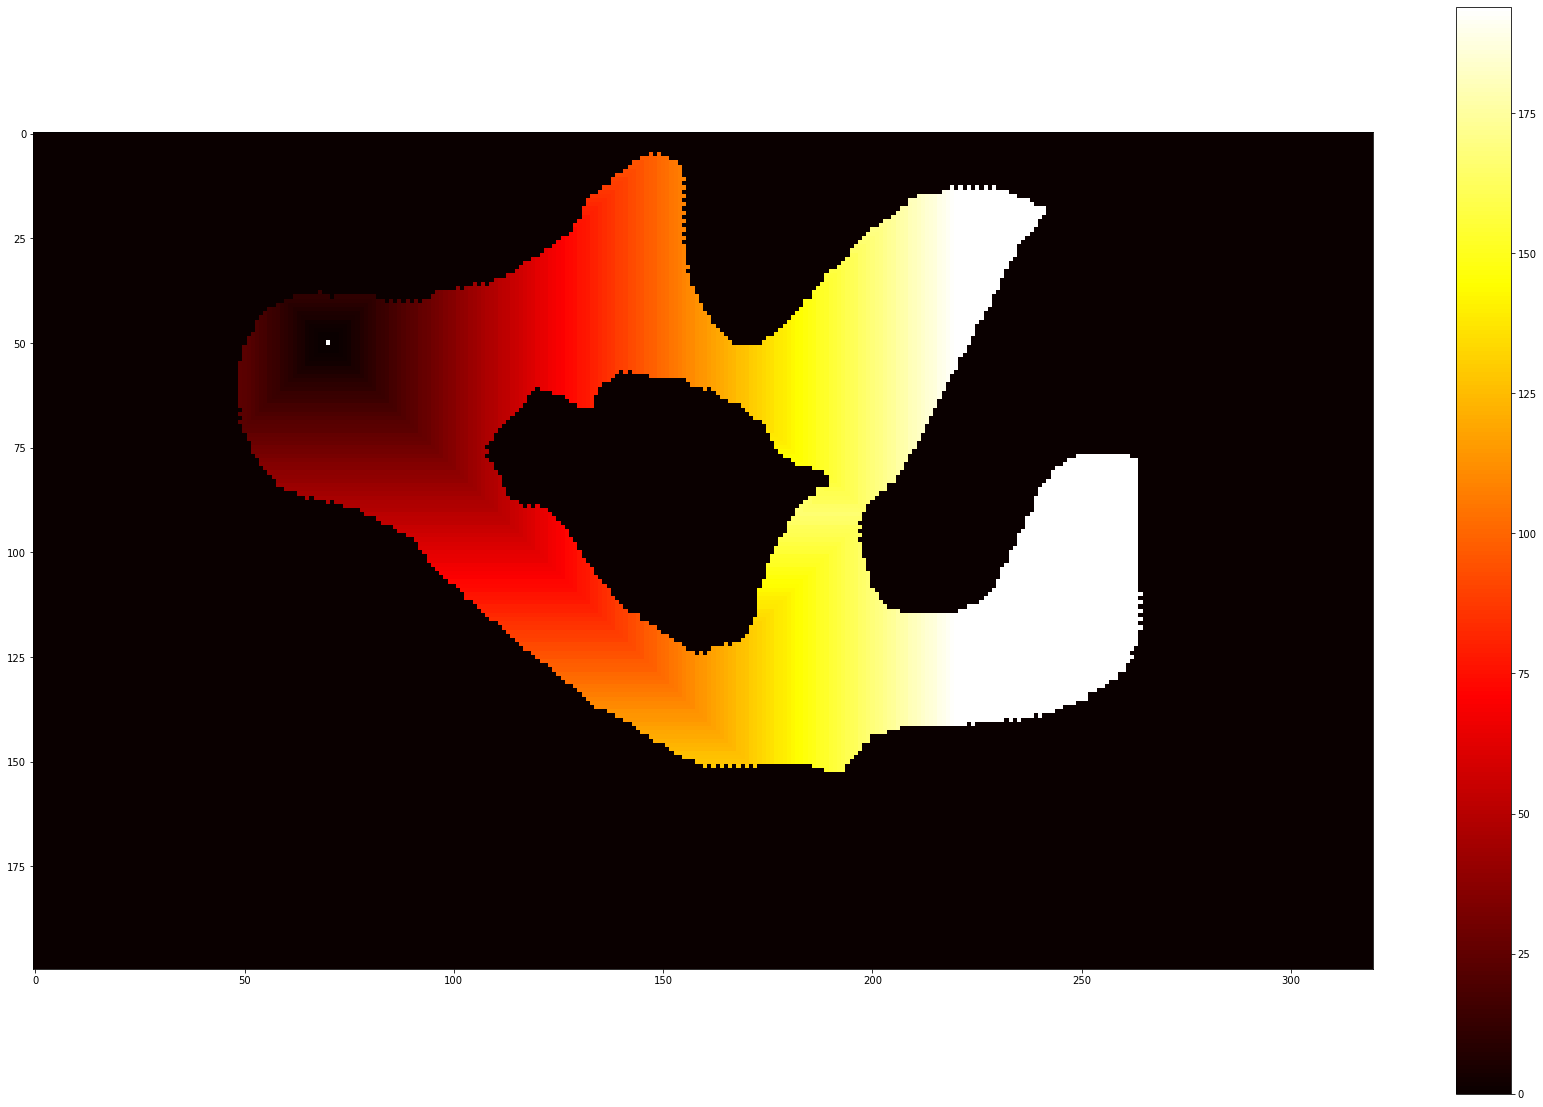

In [143]:
map(logical)